# Evaluation of Rate of Hospital Admission Related to Infections

In this notebook, we evaluate the rate of hospital admission related to common infections, including upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), urinary tract infection (UTI).

In [20]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
from datetime import date
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

In [21]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 1- Data Preparation

In [22]:
data_hosp_rate = pd.read_csv(f'../output/measures/measure_hosp_rate_binary.csv')
data_hosp_rate_sex = pd.read_csv(f'../output/measures/measure_hosp_rate_sex_binary.csv') 
data_hosp_rate_age_cat = pd.read_csv(f'../output/measures/measure_hosp_rate_age_cat_binary.csv')
data_hosp_rate_cat = pd.read_csv(f'../output/measures/measure_hosp_rate_cat.csv')
data_hosp_rate_gp = pd.read_csv(f'../output/measures/measure_hosp_rate_gp.csv')

In [23]:
# translate sex in data_hosp_rate_sex_age_cat
dict_sex = {'F': 'Female', 'M': 'Male'}
data_hosp_rate_sex = data_hosp_rate_sex.replace({"sex": dict_sex})

In [24]:
data_hosp_rate.describe(include='all')

,admitted_binary,population,value,date
count,38000.000000,38000.0,38000.000000,38000
unique,NaN,NaN,NaN,38
top,NaN,NaN,NaN,2019-01-01
freq,NaN,NaN,NaN,1000
mean,0.600000,1.0,0.600000,NaN
std,0.489904,0.0,0.489904,NaN
min,0.000000,1.0,0.000000,NaN
25%,0.000000,1.0,0.000000,NaN
50%,1.000000,1.0,1.000000,NaN
75%,1.000000,1.0,1.000000,NaN


In [25]:
data_hosp_rate_sex.describe(include='all')

,sex,admitted_binary,population,value,date
count,76,76.000000,76.000000,76.000000,76
unique,2,NaN,NaN,NaN,38
top,Female,NaN,NaN,NaN,2019-01-01
freq,38,NaN,NaN,NaN,2
mean,NaN,300.000000,500.000000,0.600092,NaN
std,NaN,12.935739,20.374494,0.013579,NaN
min,NaN,272.000000,456.000000,0.561983,NaN
25%,NaN,290.000000,483.000000,0.592770,NaN
50%,NaN,300.000000,500.000000,0.600000,NaN
75%,NaN,310.000000,517.000000,0.607377,NaN


In [26]:
data_hosp_rate_age_cat.describe(include='all')

,age_cat,admitted_binary,population,value,date
count,190,190.000000,190.000000,190.000000,190
unique,5,NaN,NaN,NaN,38
top,0-14,NaN,NaN,NaN,2019-01-01
freq,38,NaN,NaN,NaN,5
mean,NaN,120.000000,200.000000,0.599519,NaN
std,NaN,27.385355,44.012264,0.033236,NaN
min,NaN,55.000000,101.000000,0.504425,NaN
25%,NaN,118.000000,203.250000,0.575851,NaN
50%,NaN,129.000000,216.000000,0.599056,NaN
75%,NaN,139.000000,227.000000,0.619284,NaN


In [27]:
data_hosp_rate_cat.describe(include='all')

,admitted_cat,admitted_binary,population,value,date
count,418,456.000000,456.000000,456.000000,456
unique,11,NaN,NaN,NaN,38
top,A39,NaN,NaN,NaN,2019-01-01
freq,38,NaN,NaN,NaN,12
mean,NaN,50.000000,83.333333,0.600164,NaN
std,NaN,111.749111,186.281114,0.088960,NaN
min,NaN,2.000000,8.000000,0.200000,NaN
25%,NaN,13.000000,24.000000,0.549597,NaN
50%,NaN,17.000000,29.000000,0.597143,NaN
75%,NaN,21.000000,34.000000,0.657143,NaN


In [28]:
data_hosp_rate_gp.describe(include='all')

,gp_cons_admitted_binary,admitted_binary,population,value,date
count,76.000000,76.000000,76.0,76.000000,76
unique,NaN,NaN,NaN,NaN,38
top,NaN,NaN,NaN,NaN,2019-01-01
freq,NaN,NaN,NaN,NaN,2
mean,0.500000,300.000000,500.0,0.600000,NaN
std,0.503322,7.559541,0.0,0.015119,NaN
min,0.000000,281.000000,500.0,0.562000,NaN
25%,0.000000,296.000000,500.0,0.592000,NaN
50%,0.500000,300.000000,500.0,0.600000,NaN
75%,1.000000,304.000000,500.0,0.608000,NaN


## 2- Hospital admission rate

In [29]:
data_hosp_rate.head()

,admitted_binary,population,value,date
0,0.0,1,0.0,2019-01-01
1,1.0,1,1.0,2019-01-01
2,0.0,1,0.0,2019-01-01
3,1.0,1,1.0,2019-01-01
4,1.0,1,1.0,2019-01-01


In [30]:
data_hosp_rate_groupby_date = data_hosp_rate.groupby([data_hosp_rate['date']]).mean().reset_index()
data_hosp_rate_groupby_date.head()

,date,admitted_binary,population,value
0,2019-01-01,0.6,1.0,0.6
1,2019-02-01,0.6,1.0,0.6
2,2019-03-01,0.6,1.0,0.6
3,2019-04-01,0.6,1.0,0.6
4,2019-05-01,0.6,1.0,0.6


In [31]:
# # data_hosp_rate_groupby_date['date'] = data_hosp_rate_groupby_date.index

data_hosp_rate_groupby_date['date'] = pd.to_datetime(data_hosp_rate_groupby_date['date']).dt.to_period('m')
data_hosp_rate_groupby_date['date']= data_hosp_rate_groupby_date['date'].astype(str)
data_hosp_rate_groupby_date.head()

,date,admitted_binary,population,value
0,2019-01,0.6,1.0,0.6
1,2019-02,0.6,1.0,0.6
2,2019-03,0.6,1.0,0.6
3,2019-04,0.6,1.0,0.6
4,2019-05,0.6,1.0,0.6


In [32]:
data_hosp_rate_groupby_date['value'] = data_hosp_rate_groupby_date['value']*1000

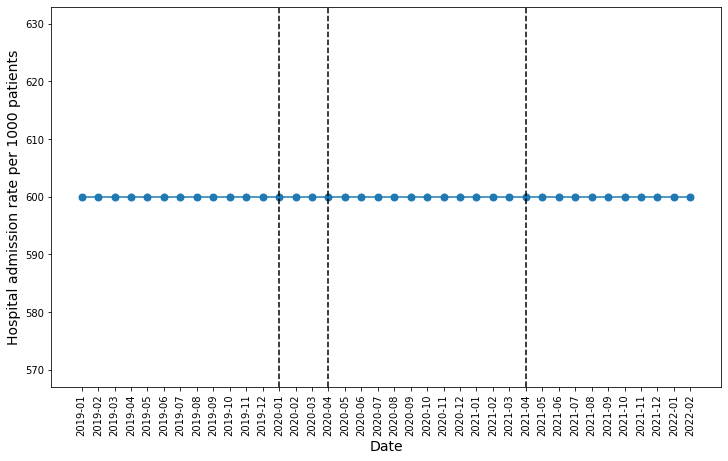

In [33]:
fig, ax1 = plt.subplots(figsize=(12, 7))

# sns.lineplot(y=data_hosp_rate_groupby_date['value'], x=data_hosp_rate_groupby_date.index, ax=ax1, linestyle='-', marker='o', markersize=7)

ax1.plot(data_hosp_rate_groupby_date['date'], data_hosp_rate_groupby_date['value'], linestyle='-', marker='o', markersize=7)

# plt.axis.set_tick_params(rotation=90)
plt.xticks(rotation=90)
# plt.grid()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
plt.axvline(x="2020-04", color='black', ls='--', lw=1.5)
plt.axvline(x="2021-04", color='black', ls='--', lw=1.5)
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_1000_patient.jpg')
plt.show()

## 3- Hospital admission with sex

In [34]:
data_hosp_rate_sex

,sex,admitted_binary,population,value,date
0,Female,292.0,487,0.599589,2019-01-01
1,Male,308.0,513,0.600390,2019-01-01
2,Female,309.0,519,0.595376,2019-02-01
3,Male,291.0,481,0.604990,2019-02-01
4,Female,298.0,502,0.593625,2019-03-01
...,...,...,...,...,...
71,Male,289.0,476,0.607143,2021-12-01
72,Female,328.0,516,0.635659,2022-01-01
73,Male,272.0,484,0.561983,2022-01-01
74,Female,281.0,488,0.575820,2022-02-01


In [35]:
data_hosp_rate_cat_sex_groupby_sex = data_hosp_rate_sex.groupby(['date', 'sex']).agg({'value': ['mean', 'min', 'max', 'sum']})
data_hosp_rate_cat_sex_groupby_sex = data_hosp_rate_cat_sex_groupby_sex.reset_index()
data_hosp_rate_cat_sex_groupby_sex.columns = ['date', 'sex', 'value_mean', 'value_min', 'value_max', 'value_sum']
data_hosp_rate_cat_sex_groupby_sex.head()

,date,sex,value_mean,value_min,value_max,value_sum
0,2019-01-01,Female,0.599589,0.599589,0.599589,0.599589
1,2019-01-01,Male,0.600390,0.600390,0.600390,0.600390
2,2019-02-01,Female,0.595376,0.595376,0.595376,0.595376
3,2019-02-01,Male,0.604990,0.604990,0.604990,0.604990
4,2019-03-01,Female,0.593625,0.593625,0.593625,0.593625


In [36]:
data_hosp_rate_cat_sex_groupby_sex['date'] = pd.to_datetime(data_hosp_rate_cat_sex_groupby_sex['date']).dt.to_period('m')
data_hosp_rate_cat_sex_groupby_sex['date']= data_hosp_rate_cat_sex_groupby_sex['date'].astype(str)
data_hosp_rate_cat_sex_groupby_sex.head()

,date,sex,value_mean,value_min,value_max,value_sum
0,2019-01,Female,0.599589,0.599589,0.599589,0.599589
1,2019-01,Male,0.600390,0.600390,0.600390,0.600390
2,2019-02,Female,0.595376,0.595376,0.595376,0.595376
3,2019-02,Male,0.604990,0.604990,0.604990,0.604990
4,2019-03,Female,0.593625,0.593625,0.593625,0.593625


In [37]:
data_hosp_rate_cat_sex_groupby_sex['value_mean'] = data_hosp_rate_cat_sex_groupby_sex['value_mean']*1000

In [38]:
data_hosp_rate_cat_sex_groupby_sex['date'] = pd.to_datetime(data_hosp_rate_cat_sex_groupby_sex['date'])
data_hosp_rate_cat_sex_groupby_sex.date = data_hosp_rate_cat_sex_groupby_sex.date.dt.strftime('%Y-%m')
data_hosp_rate_cat_sex_groupby_sex['date']

0     2019-01
1     2019-01
2     2019-02
3     2019-02
4     2019-03
       ...   
71    2021-12
72    2022-01
73    2022-01
74    2022-02
75    2022-02
Name: date, Length: 76, dtype: object

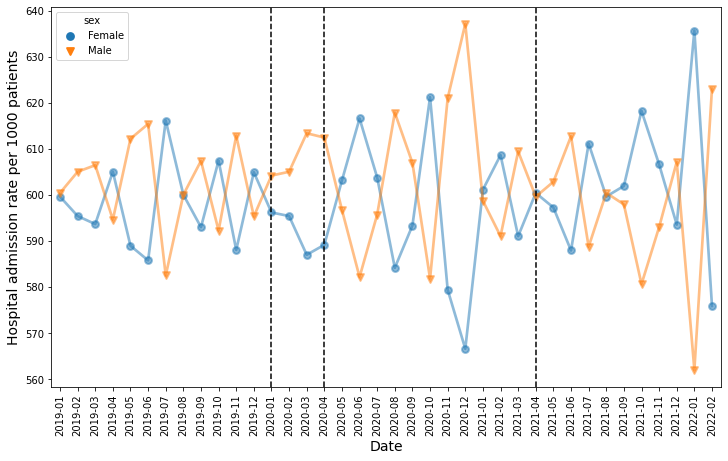

In [40]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_cat_sex_groupby_sex, y="value_mean", x="date", hue="sex", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=27, color='black', ls='--', lw=1.5) # "2021-04"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_sex_1000_patient.jpg')
plt.show()

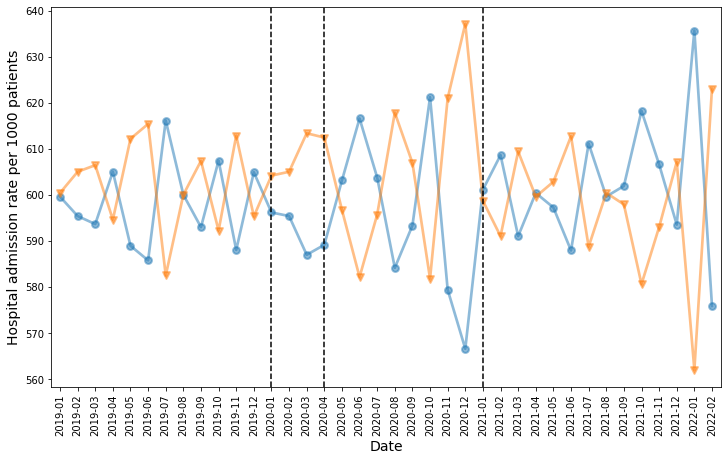

In [21]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_cat_sex_groupby_sex, y="value_mean", x="date", hue="sex", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=27, color='black', ls='--', lw=1.5) # "2021-04"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_sex_1000_patient_nolegend.jpg')
plt.show()

## 4- Hospital admission with age_cat

In [22]:
data_hosp_rate_age_cat

,age_cat,admitted_binary,population,value,date
0,0-14,74.0,112,0.660714,2019-01-01
1,15-34,125.0,221,0.565611,2019-01-01
2,35-54,129.0,211,0.611374,2019-01-01
3,55-74,143.0,228,0.627193,2019-01-01
4,75+,129.0,228,0.565789,2019-01-01
...,...,...,...,...,...
185,0-14,66.0,113,0.584071,2022-02-01
186,15-34,139.0,233,0.596567,2022-02-01
187,35-54,140.0,227,0.616740,2022-02-01
188,55-74,120.0,203,0.591133,2022-02-01


In [23]:
# data_hosp_rate_age_cat = data_hosp_rate_age_cat[data_hosp_rate_age_cat.age_cat != 0]
# data_hosp_rate_age_cat = data_hosp_rate_age_cat[data_hosp_rate_age_cat.age_cat != '0']
# data_hosp_rate_age_cat

In [24]:
data_hosp_rate_cat_age_cat_groupby_age = data_hosp_rate_age_cat.groupby(['date', 'age_cat']).agg({'value': ['mean', 'min', 'max', 'sum']})
data_hosp_rate_cat_age_cat_groupby_age = data_hosp_rate_cat_age_cat_groupby_age.reset_index()
data_hosp_rate_cat_age_cat_groupby_age.columns = ['date', 'age', 'value_mean', 'value_min', 'value_max', 'value_sum']
data_hosp_rate_cat_age_cat_groupby_age.head()

,date,age,value_mean,value_min,value_max,value_sum
0,2019-01-01,0-14,0.660714,0.660714,0.660714,0.660714
1,2019-01-01,15-34,0.565611,0.565611,0.565611,0.565611
2,2019-01-01,35-54,0.611374,0.611374,0.611374,0.611374
3,2019-01-01,55-74,0.627193,0.627193,0.627193,0.627193
4,2019-01-01,75+,0.565789,0.565789,0.565789,0.565789


In [25]:
data_hosp_rate_cat_age_cat_groupby_age.date = pd.to_datetime(data_hosp_rate_cat_age_cat_groupby_age.date)

data_hosp_rate_cat_age_cat_groupby_age.date = data_hosp_rate_cat_age_cat_groupby_age.date.dt.strftime('%Y-%m')

data_hosp_rate_cat_age_cat_groupby_age.head()

,date,age,value_mean,value_min,value_max,value_sum
0,2019-01,0-14,0.660714,0.660714,0.660714,0.660714
1,2019-01,15-34,0.565611,0.565611,0.565611,0.565611
2,2019-01,35-54,0.611374,0.611374,0.611374,0.611374
3,2019-01,55-74,0.627193,0.627193,0.627193,0.627193
4,2019-01,75+,0.565789,0.565789,0.565789,0.565789


In [26]:
data_hosp_rate_cat_age_cat_groupby_age['value_mean'] = data_hosp_rate_cat_age_cat_groupby_age['value_mean']*1000

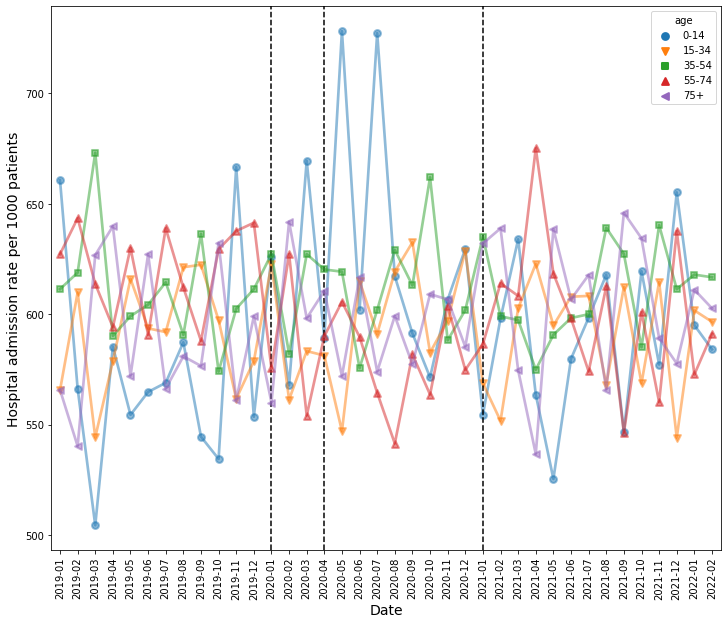

In [27]:
plt.figure(figsize=(12,10))

g = sns.pointplot(data=data_hosp_rate_cat_age_cat_groupby_age, y="value_mean", x="date", hue="age", markers=['o', 'v', 's', '^', '<', '*'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=27, color='black', ls='--', lw=1.5) # "2021-04"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_age_1000_patient.jpg')
plt.show()

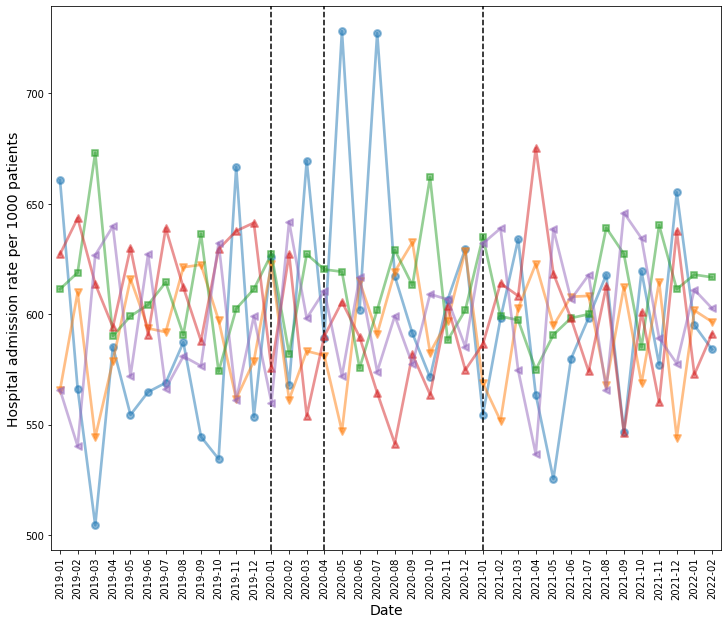

In [28]:
plt.figure(figsize=(12,10))

g = sns.pointplot(data=data_hosp_rate_cat_age_cat_groupby_age, y="value_mean", x="date", hue="age", markers=['o', 'v', 's', '^', '<', '*'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=27, color='black', ls='--', lw=1.5) # "2021-04"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_age_1000_patient_nolegend.jpg')
plt.show()

## 5- Hospital admission with admission category

In [29]:
print(f'shape of data_hosp_rate_cat: {data_hosp_rate_cat.shape}\n')
data_hosp_rate_cat

shape of data_hosp_rate_cat: (456, 5)



,admitted_cat,admitted_binary,population,value,date
0,NaN,412.0,700,0.588571,2019-01-01
1,A39,16.0,29,0.551724,2019-01-01
2,A40,16.0,23,0.695652,2019-01-01
3,A41,9.0,16,0.562500,2019-01-01
4,B95,10.0,15,0.666667,2019-01-01
...,...,...,...,...,...
451,J13,25.0,34,0.735294,2022-02-01
452,K05,23.0,36,0.638889,2022-02-01
453,L01,16.0,28,0.571429,2022-02-01
454,M00,11.0,21,0.523810,2022-02-01


In [30]:
data_hosp_rate_sex_groupby_date = data_hosp_rate_sex.groupby([data_hosp_rate_sex['date']]).sum().reset_index()
data_hosp_rate_sex_groupby_date['date'] = pd.to_datetime(data_hosp_rate_sex_groupby_date['date']).dt.to_period('m')
data_hosp_rate_sex_groupby_date['date']= data_hosp_rate_sex_groupby_date['date'].astype(str)
data_hosp_rate_sex_groupby_date#.head()

,date,admitted_binary,population,value
0,2019-01,600.0,1000,1.199979
1,2019-02,600.0,1000,1.200365
2,2019-03,600.0,1000,1.200051
3,2019-04,600.0,1000,1.199604
4,2019-05,600.0,1000,1.201069
5,2019-06,600.0,1000,1.201126
6,2019-07,600.0,1000,1.198586
7,2019-08,600.0,1000,1.200000
8,2019-09,600.0,1000,1.200317
9,2019-10,600.0,1000,1.199635


In [31]:
data_hosp_rate_cat = data_hosp_rate_cat.replace(np.nan, 'NA', regex=True)
data_hosp_rate_cat

,admitted_cat,admitted_binary,population,value,date
0,NA,412.0,700,0.588571,2019-01-01
1,A39,16.0,29,0.551724,2019-01-01
2,A40,16.0,23,0.695652,2019-01-01
3,A41,9.0,16,0.562500,2019-01-01
4,B95,10.0,15,0.666667,2019-01-01
...,...,...,...,...,...
451,J13,25.0,34,0.735294,2022-02-01
452,K05,23.0,36,0.638889,2022-02-01
453,L01,16.0,28,0.571429,2022-02-01
454,M00,11.0,21,0.523810,2022-02-01


In [32]:
data_hosp_rate_cat[data_hosp_rate_cat['admitted_cat']=='NA'][['date', 'admitted_cat', 'admitted_binary', 'population', 'value']]

,date,admitted_cat,admitted_binary,population,value
0,2019-01-01,NA,412.0,700,0.588571
12,2019-02-01,NA,424.0,700,0.605714
24,2019-03-01,NA,426.0,700,0.608571
36,2019-04-01,NA,415.0,700,0.592857
48,2019-05-01,NA,425.0,700,0.607143
60,2019-06-01,NA,415.0,700,0.592857
72,2019-07-01,NA,422.0,700,0.602857
84,2019-08-01,NA,426.0,700,0.608571
96,2019-09-01,NA,418.0,700,0.597143
108,2019-10-01,NA,424.0,700,0.605714


In [33]:
data_hosp_rate_cat = data_hosp_rate_cat[data_hosp_rate_cat.admitted_cat != 'NA']
data_hosp_rate_cat

,admitted_cat,admitted_binary,population,value,date
1,A39,16.0,29,0.551724,2019-01-01
2,A40,16.0,23,0.695652,2019-01-01
3,A41,9.0,16,0.562500,2019-01-01
4,B95,10.0,15,0.666667,2019-01-01
5,G00,22.0,32,0.687500,2019-01-01
...,...,...,...,...,...
451,J13,25.0,34,0.735294,2022-02-01
452,K05,23.0,36,0.638889,2022-02-01
453,L01,16.0,28,0.571429,2022-02-01
454,M00,11.0,21,0.523810,2022-02-01


In [34]:
# data_hosp_rate_cat[data_hosp_rate_cat["admitted_cat"].str.contains("A40")]
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('A40'), 'admitted_cat'] = 'Sepsis'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('A41'), 'admitted_cat'] = 'Sepsis'
# data_hosp_rate_cat.loc[((data_hosp_rate_cat['admitted_cat'].str.contains('A40')) & (data_hosp_rate_cat['admitted_cat'].str.contains('A41'))), 'admitted_cat'] = 'Sepsis'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('N39'), 'admitted_cat'] = 'UTI-related'
data_hosp_rate_cat

,admitted_cat,admitted_binary,population,value,date
1,A39,16.0,29,0.551724,2019-01-01
2,Sepsis,16.0,23,0.695652,2019-01-01
3,Sepsis,9.0,16,0.562500,2019-01-01
4,B95,10.0,15,0.666667,2019-01-01
5,G00,22.0,32,0.687500,2019-01-01
...,...,...,...,...,...
451,J13,25.0,34,0.735294,2022-02-01
452,K05,23.0,36,0.638889,2022-02-01
453,L01,16.0,28,0.571429,2022-02-01
454,M00,11.0,21,0.523810,2022-02-01


In [35]:
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('A'), 'admitted_cat'] = 'A'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('B'), 'admitted_cat'] = 'B'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('G'), 'admitted_cat'] = 'G'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('H'), 'admitted_cat'] = 'H'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('J'), 'admitted_cat'] = 'J'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('K'), 'admitted_cat'] = 'K'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('L'), 'admitted_cat'] = 'L'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('M'), 'admitted_cat'] = 'M'
data_hosp_rate_cat.loc[data_hosp_rate_cat['admitted_cat'].str.contains('N'), 'admitted_cat'] = 'N'

data_hosp_rate_cat

,admitted_cat,admitted_binary,population,value,date
1,A,16.0,29,0.551724,2019-01-01
2,Sepsis,16.0,23,0.695652,2019-01-01
3,Sepsis,9.0,16,0.562500,2019-01-01
4,B,10.0,15,0.666667,2019-01-01
5,G,22.0,32,0.687500,2019-01-01
...,...,...,...,...,...
451,J,25.0,34,0.735294,2022-02-01
452,K,23.0,36,0.638889,2022-02-01
453,L,16.0,28,0.571429,2022-02-01
454,M,11.0,21,0.523810,2022-02-01


In [36]:
data_hosp_rate_cat.date = pd.to_datetime(data_hosp_rate_cat.date)

data_hosp_rate_cat.date = data_hosp_rate_cat.date.dt.strftime('%Y-%m')

data_hosp_rate_cat#.head()

,admitted_cat,admitted_binary,population,value,date
1,A,16.0,29,0.551724,2019-01
2,Sepsis,16.0,23,0.695652,2019-01
3,Sepsis,9.0,16,0.562500,2019-01
4,B,10.0,15,0.666667,2019-01
5,G,22.0,32,0.687500,2019-01
...,...,...,...,...,...
451,J,25.0,34,0.735294,2022-02
452,K,23.0,36,0.638889,2022-02
453,L,16.0,28,0.571429,2022-02
454,M,11.0,21,0.523810,2022-02


In [37]:
data_hosp_rate_cat_groupby_date_admitted_cat = data_hosp_rate_cat.groupby(['date', 'admitted_cat'], as_index=False).sum()
data_hosp_rate_cat_groupby_date_admitted_cat

,date,admitted_cat,admitted_binary,population,value
0,2019-01,A,16.0,29,0.551724
1,2019-01,B,10.0,15,0.666667
2,2019-01,G,22.0,32,0.687500
3,2019-01,H,19.0,26,0.730769
4,2019-01,J,23.0,36,0.638889
...,...,...,...,...,...
375,2022-02,K,23.0,36,0.638889
376,2022-02,L,16.0,28,0.571429
377,2022-02,M,11.0,21,0.523810
378,2022-02,N,18.0,37,0.486486


In [38]:
data_hosp_rate_cat_groupby_date_admitted_cat[data_hosp_rate_cat_groupby_date_admitted_cat['date']=='2019-01'][['date', 'admitted_cat', 'admitted_binary', 'population', 'value']]

,date,admitted_cat,admitted_binary,population,value
0,2019-01,A,16.0,29,0.551724
1,2019-01,B,10.0,15,0.666667
2,2019-01,G,22.0,32,0.687500
3,2019-01,H,19.0,26,0.730769
4,2019-01,J,23.0,36,0.638889
5,2019-01,K,21.0,31,0.677419
6,2019-01,L,19.0,37,0.513514
7,2019-01,M,19.0,29,0.655172
8,2019-01,N,14.0,26,0.538462
9,2019-01,Sepsis,25.0,39,1.258152


In [39]:
data_hosp_rate_cat_groupby_date_admitted_cat['admitted_binary_sum'] = data_hosp_rate_cat_groupby_date_admitted_cat['admitted_binary'].groupby(data_hosp_rate_cat_groupby_date_admitted_cat['date']).transform('sum')
data_hosp_rate_cat_groupby_date_admitted_cat

,date,admitted_cat,admitted_binary,population,value,admitted_binary_sum
0,2019-01,A,16.0,29,0.551724,188.0
1,2019-01,B,10.0,15,0.666667,188.0
2,2019-01,G,22.0,32,0.687500,188.0
3,2019-01,H,19.0,26,0.730769,188.0
4,2019-01,J,23.0,36,0.638889,188.0
...,...,...,...,...,...,...
375,2022-02,K,23.0,36,0.638889,183.0
376,2022-02,L,16.0,28,0.571429,183.0
377,2022-02,M,11.0,21,0.523810,183.0
378,2022-02,N,18.0,37,0.486486,183.0


In [45]:
# drop numbers less than or equal to 5
data_hosp_rate_cat_groupby_date_admitted_cat = data_hosp_rate_cat_groupby_date_admitted_cat[~(data_hosp_rate_cat_groupby_date_admitted_cat['admitted_binary'] <= 5)]

In [40]:
data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated'] = (data_hosp_rate_cat_groupby_date_admitted_cat['admitted_binary']/data_hosp_rate_cat_groupby_date_admitted_cat['admitted_binary_sum'])*100
data_hosp_rate_cat_groupby_date_admitted_cat

,date,admitted_cat,admitted_binary,population,value,admitted_binary_sum,value_calculated
0,2019-01,A,16.0,29,0.551724,188.0,8.510638
1,2019-01,B,10.0,15,0.666667,188.0,5.319149
2,2019-01,G,22.0,32,0.687500,188.0,11.702128
3,2019-01,H,19.0,26,0.730769,188.0,10.106383
4,2019-01,J,23.0,36,0.638889,188.0,12.234043
...,...,...,...,...,...,...,...
375,2022-02,K,23.0,36,0.638889,183.0,12.568306
376,2022-02,L,16.0,28,0.571429,183.0,8.743169
377,2022-02,M,11.0,21,0.523810,183.0,6.010929
378,2022-02,N,18.0,37,0.486486,183.0,9.836066


In [41]:
data_hosp_rate_cat_groupby_date_admitted_cat[data_hosp_rate_cat_groupby_date_admitted_cat['date']=='2019-01'][['date', 'admitted_cat', 'admitted_binary', 'population', 'value', 'admitted_binary_sum', 'value_calculated']]

,date,admitted_cat,admitted_binary,population,value,admitted_binary_sum,value_calculated
0,2019-01,A,16.0,29,0.551724,188.0,8.510638
1,2019-01,B,10.0,15,0.666667,188.0,5.319149
2,2019-01,G,22.0,32,0.687500,188.0,11.702128
3,2019-01,H,19.0,26,0.730769,188.0,10.106383
4,2019-01,J,23.0,36,0.638889,188.0,12.234043
5,2019-01,K,21.0,31,0.677419,188.0,11.170213
6,2019-01,L,19.0,37,0.513514,188.0,10.106383
7,2019-01,M,19.0,29,0.655172,188.0,10.106383
8,2019-01,N,14.0,26,0.538462,188.0,7.446809
9,2019-01,Sepsis,25.0,39,1.258152,188.0,13.297872


In [42]:
data_hosp_rate_cat_groupby_date_admitted_cat[data_hosp_rate_cat_groupby_date_admitted_cat['date']=='2019-01'][['date', 'admitted_cat', 'admitted_binary', 'population', 'value', 'admitted_binary_sum', 'value_calculated']].value_calculated.sum()

99.99999999999999

In [43]:
# data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated'] = data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated']*1000
# data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated_ii'] = data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated_ii']*1000

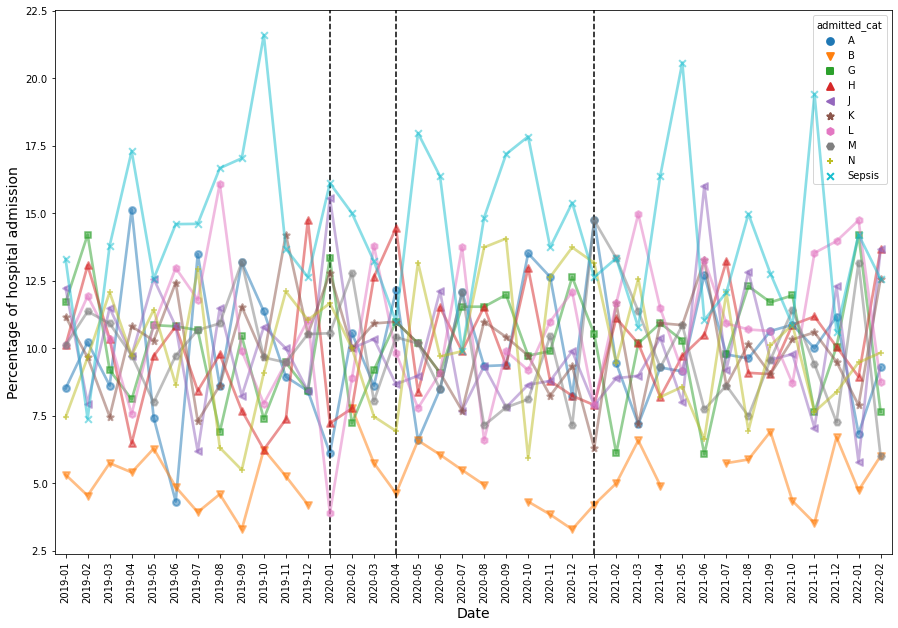

In [46]:
plt.figure(figsize=(15,10))

g = sns.pointplot(data=data_hosp_rate_cat_groupby_date_admitted_cat, y="value_calculated", x="date", hue="admitted_cat", 
                markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'], 
                plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=27, color='black', ls='--', lw=1.5) # "2021-04"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Percentage of hospital admission', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_percentage_cat.jpg')
plt.show()

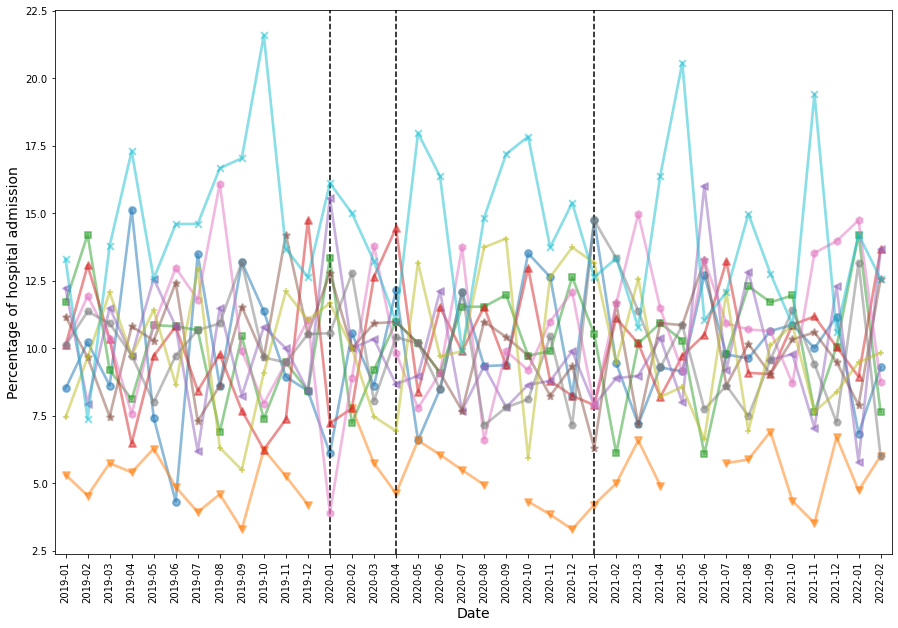

In [47]:
plt.figure(figsize=(15,10))

g = sns.pointplot(data=data_hosp_rate_cat_groupby_date_admitted_cat, y="value_calculated", x="date", hue="admitted_cat", 
                markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'], 
                plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=27, color='black', ls='--', lw=1.5) # "2021-04"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Percentage of hospital admission', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_percentage_cat_nolegend.jpg')
plt.show()

In [48]:
data_hosp_rate_cat_groupby_date_admitted_cat.head()

,date,admitted_cat,admitted_binary,population,value,admitted_binary_sum,value_calculated
0,2019-01,A,16.0,29,0.551724,188.0,8.510638
1,2019-01,B,10.0,15,0.666667,188.0,5.319149
2,2019-01,G,22.0,32,0.687500,188.0,11.702128
3,2019-01,H,19.0,26,0.730769,188.0,10.106383
4,2019-01,J,23.0,36,0.638889,188.0,12.234043


In [49]:
data_hosp_rate_sex_groupby_date.head()

,date,admitted_binary,population,value
0,2019-01,600.0,1000,1.199979
1,2019-02,600.0,1000,1.200365
2,2019-03,600.0,1000,1.200051
3,2019-04,600.0,1000,1.199604
4,2019-05,600.0,1000,1.201069


In [50]:
#add population_group_by_sex to calculate rate of hospital admission with hosp cat
data_hosp_rate_cat_groupby_date_admitted_cat['population_group_by_sex'] = np.nan
col_population = data_hosp_rate_cat_groupby_date_admitted_cat.columns.get_loc('population_group_by_sex')
col_date = data_hosp_rate_cat_groupby_date_admitted_cat.columns.get_loc('date')
col_population_sex_groupby_date = data_hosp_rate_sex_groupby_date.columns.get_loc('population')
col_date_sex_groupby = data_hosp_rate_sex_groupby_date.columns.get_loc('date')

for idx, x in enumerate(data_hosp_rate_cat_groupby_date_admitted_cat['population_group_by_sex']):
    for idy, y in enumerate(data_hosp_rate_sex_groupby_date['population']):
        if data_hosp_rate_sex_groupby_date.iat[idy, col_date_sex_groupby] == data_hosp_rate_cat_groupby_date_admitted_cat.iat[idx, col_date]:
            data_hosp_rate_cat_groupby_date_admitted_cat.iat[idx, col_population] = data_hosp_rate_sex_groupby_date.iat[idy, col_population_sex_groupby_date]

data_hosp_rate_cat_groupby_date_admitted_cat

,date,admitted_cat,admitted_binary,population,value,admitted_binary_sum,value_calculated,population_group_by_sex
0,2019-01,A,16.0,29,0.551724,188.0,8.510638,1000.0
1,2019-01,B,10.0,15,0.666667,188.0,5.319149,1000.0
2,2019-01,G,22.0,32,0.687500,188.0,11.702128,1000.0
3,2019-01,H,19.0,26,0.730769,188.0,10.106383,1000.0
4,2019-01,J,23.0,36,0.638889,188.0,12.234043,1000.0
...,...,...,...,...,...,...,...,...
375,2022-02,K,23.0,36,0.638889,183.0,12.568306,1000.0
376,2022-02,L,16.0,28,0.571429,183.0,8.743169,1000.0
377,2022-02,M,11.0,21,0.523810,183.0,6.010929,1000.0
378,2022-02,N,18.0,37,0.486486,183.0,9.836066,1000.0


In [94]:
data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated_ii'] = data_hosp_rate_cat_groupby_date_admitted_cat['admitted_binary']/data_hosp_rate_cat_groupby_date_admitted_cat['population_group_by_sex']
data_hosp_rate_cat_groupby_date_admitted_cat

,date,admitted_cat,admitted_binary,population,value,admitted_binary_sum,value_calculated,population_group_by_sex,value_calculated_ii
0,2019-01,A,20.0,35,0.571429,181.0,0.110497,1000.0,0.020
1,2019-01,B,4.0,15,0.266667,181.0,0.022099,1000.0,0.004
2,2019-01,G,16.0,21,0.761905,181.0,0.088398,1000.0,0.016
3,2019-01,H,12.0,23,0.521739,181.0,0.066298,1000.0,0.012
4,2019-01,J,17.0,33,0.515152,181.0,0.093923,1000.0,0.017
...,...,...,...,...,...,...,...,...,...
375,2022-02,K,17.0,27,0.629630,201.0,0.084577,1000.0,0.017
376,2022-02,L,19.0,30,0.633333,201.0,0.094527,1000.0,0.019
377,2022-02,M,29.0,32,0.906250,201.0,0.144279,1000.0,0.029
378,2022-02,N,18.0,30,0.600000,201.0,0.089552,1000.0,0.018


In [ ]:
# drop numbers less than or equal to 5 again (if any!)
data_hosp_rate_cat_groupby_date_admitted_cat = data_hosp_rate_cat_groupby_date_admitted_cat[~(data_hosp_rate_cat_groupby_date_admitted_cat['admitted_binary'] <= 5)]

In [95]:
data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated_ii'] = data_hosp_rate_cat_groupby_date_admitted_cat['value_calculated_ii']*1000

In [41]:
#print data_hosp_rate_cat_groupby_date_admitted_cat to csv
data_hosp_rate_cat_groupby_date_admitted_cat.to_csv(f'../output/hospitalisation_rate/data_hosp_rate_cat_groupby_date_admitted_cat.csv')

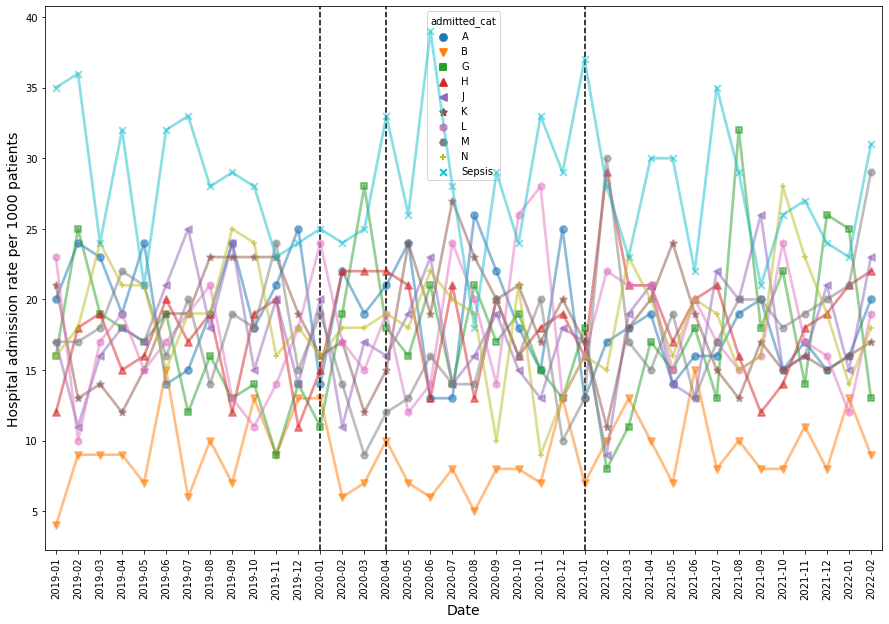

In [96]:
plt.figure(figsize=(15,10))

g = sns.pointplot(data=data_hosp_rate_cat_groupby_date_admitted_cat, y="value_calculated_ii", x="date", hue="admitted_cat", 
                markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'], 
                plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=27, color='black', ls='--', lw=1.5) # "2021-04"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_cat_1000_patient.jpg')
plt.show()

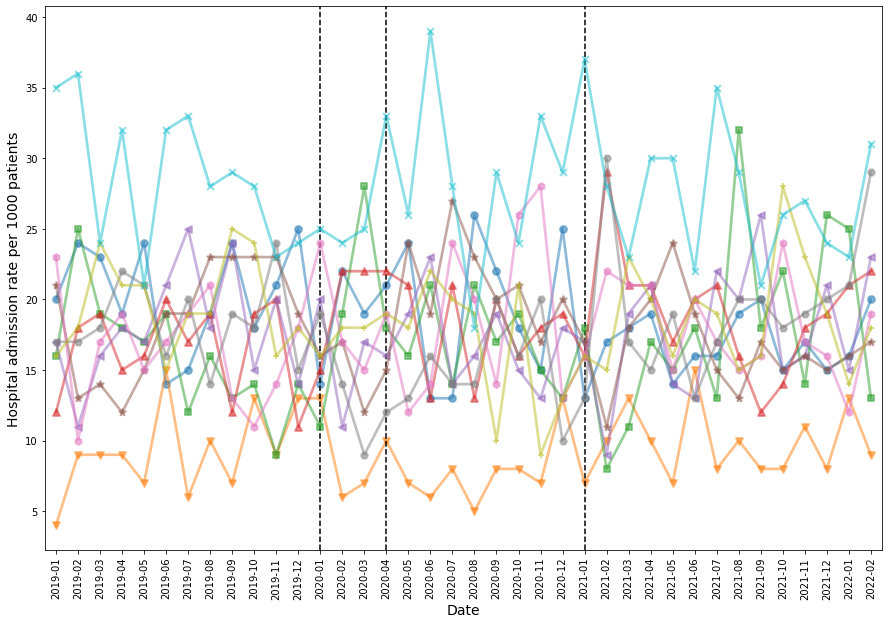

In [97]:
plt.figure(figsize=(15,10))

g = sns.pointplot(data=data_hosp_rate_cat_groupby_date_admitted_cat, y="value_calculated_ii", x="date", hue="admitted_cat", 
                markers=['o', 'v', 's', '^', '<', '*', 'h', 'H', '+', 'x', '1', '2', '3', '4', '5'], 
                plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=27, color='black', ls='--', lw=1.5) # "2021-04"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_cat_1000_patient_nolegend.jpg')
plt.show()

## 4- Hospital admission rate with GP consultation

In [60]:
data_hosp_rate_gp

,gp_cons_admitted_binary,admitted_binary,population,value,date
0,0,292.0,500,0.584,2019-01-01
1,1,308.0,500,0.616,2019-01-01
2,0,301.0,500,0.602,2019-02-01
3,1,299.0,500,0.598,2019-02-01
4,0,306.0,500,0.612,2019-03-01
...,...,...,...,...,...
71,1,304.0,500,0.608,2021-12-01
72,0,293.0,500,0.586,2022-01-01
73,1,307.0,500,0.614,2022-01-01
74,0,311.0,500,0.622,2022-02-01


In [61]:
data_hosp_rate_gp_groupby_date = data_hosp_rate_gp.groupby(['date','gp_cons_admitted_binary'], as_index=False)['value'].mean()#sum()
# data_hosp_rate_gp_groupby_date = data_hosp_rate_gp.groupby(['date','gp_cons_admitted_binary'], as_index=False)['value'].sum()
data_hosp_rate_gp_groupby_date['value_sum'] = data_hosp_rate_gp.groupby(['date','gp_cons_admitted_binary'], as_index=False)['value'].sum().value #data_hosp_rate_gp.groupby(['date','gp_cons_admitted_binary'], as_index=False)['value'].sum()
data_hosp_rate_gp_groupby_date

,date,gp_cons_admitted_binary,value,value_sum
0,2019-01-01,0,0.584,0.584
1,2019-01-01,1,0.616,0.616
2,2019-02-01,0,0.602,0.602
3,2019-02-01,1,0.598,0.598
4,2019-03-01,0,0.612,0.612
...,...,...,...,...
71,2021-12-01,1,0.608,0.608
72,2022-01-01,0,0.586,0.586
73,2022-01-01,1,0.614,0.614
74,2022-02-01,0,0.622,0.622


In [64]:
data_hosp_rate_gp_groupby_date.date = pd.to_datetime(data_hosp_rate_gp_groupby_date.date)

data_hosp_rate_gp_groupby_date.date = data_hosp_rate_gp_groupby_date.date.dt.strftime('%Y-%m')

data_hosp_rate_gp_groupby_date.head()

,date,gp_cons_admitted_binary,value,value_sum
0,2019-01,0,0.584,0.584
1,2019-01,1,0.616,0.616
2,2019-02,0,0.602,0.602
3,2019-02,1,0.598,0.598
4,2019-03,0,0.612,0.612


In [65]:
data_hosp_rate_gp_groupby_date['value'] = data_hosp_rate_gp_groupby_date['value']*1000

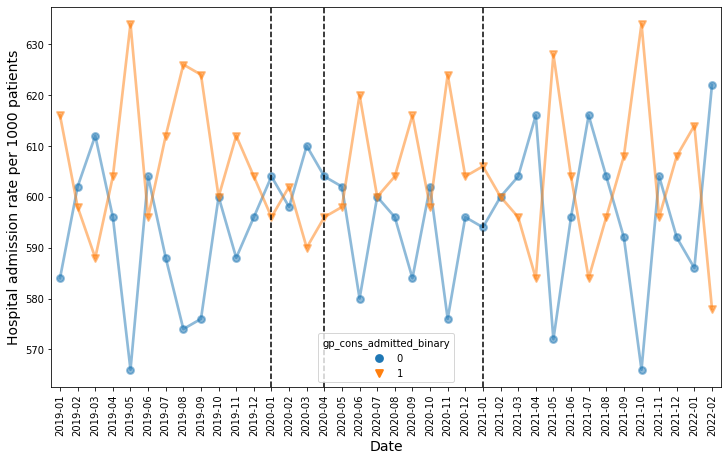

In [66]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_gp_groupby_date, y="value", x="date", hue="gp_cons_admitted_binary", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=27, color='black', ls='--', lw=1.5) # "2021-04"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# g.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_gp_1000_patient.jpg')
plt.show()

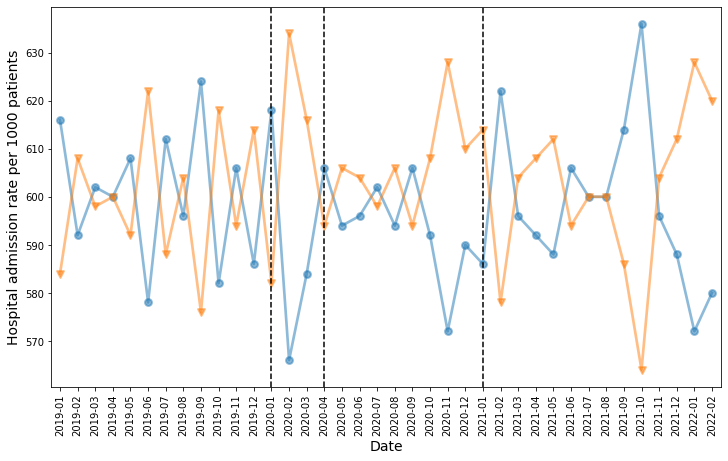

In [85]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_gp_groupby_date, y="value", x="date", hue="gp_cons_admitted_binary", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=27, color='black', ls='--', lw=1.5) # "2021-04"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Hospital admission rate per 1000 patients', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# ax.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_rate_gp_1000_patient_nolegend.jpg')
plt.show()

In [67]:
data_hosp_rate_gp.date = pd.to_datetime(data_hosp_rate_gp.date)
data_hosp_rate_gp.date = data_hosp_rate_gp.date.dt.strftime('%Y-%m')
data_hosp_rate_gp#.head()

,gp_cons_admitted_binary,admitted_binary,population,value,date
0,0,292.0,500,0.584,2019-01
1,1,308.0,500,0.616,2019-01
2,0,301.0,500,0.602,2019-02
3,1,299.0,500,0.598,2019-02
4,0,306.0,500,0.612,2019-03
...,...,...,...,...,...
71,1,304.0,500,0.608,2021-12
72,0,293.0,500,0.586,2022-01
73,1,307.0,500,0.614,2022-01
74,0,311.0,500,0.622,2022-02


In [68]:
data_hosp_rate_sex_groupby_date.head()

,date,admitted_binary,population,value
0,2019-01,600.0,1000,1.199920
1,2019-02,600.0,1000,1.199779
2,2019-03,600.0,1000,1.200131
3,2019-04,600.0,1000,1.200120
4,2019-05,600.0,1000,1.200564


In [69]:
#add population_group_by_sex to calculate percentage of hospital admission with gp cons
data_hosp_rate_gp['population_group_by_sex'] = np.nan
col_population = data_hosp_rate_gp.columns.get_loc('population_group_by_sex')
col_date = data_hosp_rate_gp.columns.get_loc('date')
col_admitted = data_hosp_rate_sex_groupby_date.columns.get_loc('admitted_binary')
col_date_sex_groupby = data_hosp_rate_sex_groupby_date.columns.get_loc('date')

for idx, x in enumerate(data_hosp_rate_gp['population_group_by_sex']):
    for idy, y in enumerate(data_hosp_rate_sex_groupby_date['admitted_binary']):
        if data_hosp_rate_sex_groupby_date.iat[idy, col_date_sex_groupby] == data_hosp_rate_gp.iat[idx, col_date]:
            data_hosp_rate_gp.iat[idx, col_population] = data_hosp_rate_sex_groupby_date.iat[idy, col_admitted]

data_hosp_rate_gp

,gp_cons_admitted_binary,admitted_binary,population,value,date,population_group_by_sex
0,0,292.0,500,0.584,2019-01,600.0
1,1,308.0,500,0.616,2019-01,600.0
2,0,301.0,500,0.602,2019-02,600.0
3,1,299.0,500,0.598,2019-02,600.0
4,0,306.0,500,0.612,2019-03,600.0
...,...,...,...,...,...,...
71,1,304.0,500,0.608,2021-12,600.0
72,0,293.0,500,0.586,2022-01,600.0
73,1,307.0,500,0.614,2022-01,600.0
74,0,311.0,500,0.622,2022-02,600.0


In [70]:
data_hosp_rate_gp['value_calculated_ii'] = (data_hosp_rate_gp['admitted_binary']/data_hosp_rate_gp['population_group_by_sex'])*100
data_hosp_rate_gp

,gp_cons_admitted_binary,admitted_binary,population,value,date,population_group_by_sex,value_calculated_ii
0,0,292.0,500,0.584,2019-01,600.0,48.666667
1,1,308.0,500,0.616,2019-01,600.0,51.333333
2,0,301.0,500,0.602,2019-02,600.0,50.166667
3,1,299.0,500,0.598,2019-02,600.0,49.833333
4,0,306.0,500,0.612,2019-03,600.0,51.000000
...,...,...,...,...,...,...,...
71,1,304.0,500,0.608,2021-12,600.0,50.666667
72,0,293.0,500,0.586,2022-01,600.0,48.833333
73,1,307.0,500,0.614,2022-01,600.0,51.166667
74,0,311.0,500,0.622,2022-02,600.0,51.833333


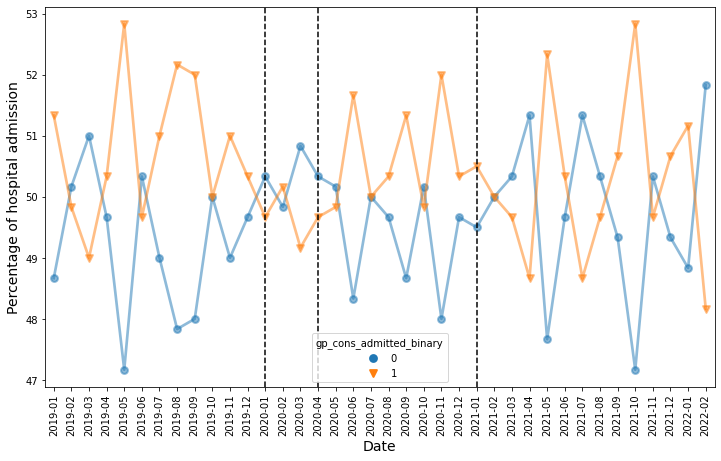

In [71]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_gp, y="value_calculated_ii", x="date", hue="gp_cons_admitted_binary", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=27, color='black', ls='--', lw=1.5) # "2021-04"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Percentage of hospital admission', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
# plt.legend([],[], frameon=False)
# g.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_percentage_gp_couns.jpg')
plt.show()

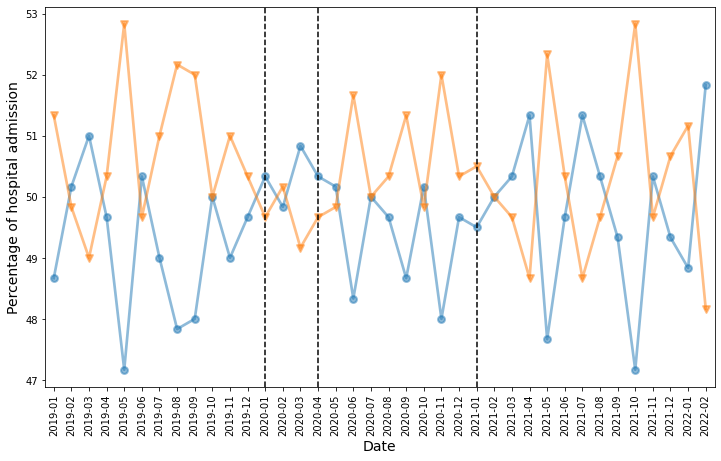

In [72]:
plt.figure(figsize=(12,7))

g = sns.pointplot(data=data_hosp_rate_gp, y="value_calculated_ii", x="date", hue="gp_cons_admitted_binary", markers=['o', 'v'], plot_kws=dict(alpha=0.5))

plt.setp(g.collections, alpha=.5) #alpha for markers
plt.setp(g.lines, alpha=.5) #alpha for line

g.axvline(x=12, color='black', ls='--', lw=1.5) #"2020-01"
g.axvline(x=15, color='black', ls='--', lw=1.5) # "2020-04"
g.axvline(x=27, color='black', ls='--', lw=1.5) # "2021-04"

plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Percentage of hospital admission', fontsize=14)
# plt.title('Rate of hospital admission ralated to common infections', fontsize=16)
plt.legend([],[], frameon=False)
# g.set_xticklabels([])
# plt.tight_layout()
plt.savefig('../output/hospitalisation_rate/hospital_admission_percentage_gp_couns_nolegend.jpg')
plt.show()